In [ ]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.layers import Conv1D , GlobalMaxPooling1D,MaxPooling1D,Conv2D
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, Dense

In [ ]:
num_classes = 3

embed_num_dims = 200
max_seq_len = 1000


class_names = ['Positive', 'Negative','Neutral']

In [ ]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
      df.apply(np.random.shuffle, axis=axis)
    return df

In [ ]:
data= pd.read_csv('/content/Final.csv')

In [ ]:
print(data.columns)

Index(['Comment', 'Category'], dtype='object')


In [ ]:
data.isnull().values.any()

True

In [ ]:
data.dropna(subset = ['Comment','Category'], inplace =True )

In [ ]:
data.isnull().values.any()

False

<Axes: xlabel='Category', ylabel='count'>

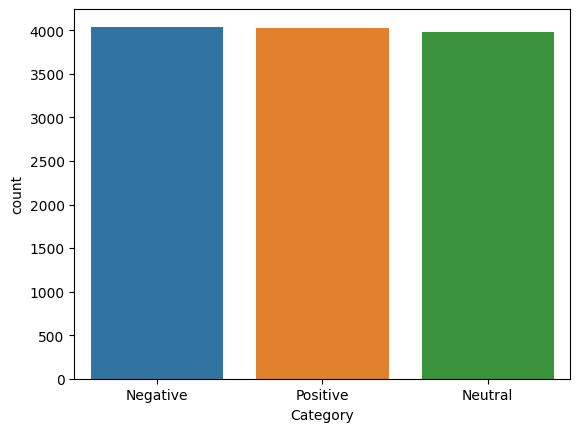

In [ ]:
import seaborn as sns
sns.countplot(x='Category', data=data)

In [ ]:
data.sort_values(by='Category', axis=0, inplace=True)

data.set_index(keys=['Category'], drop=False,inplace=True)
Categorys=data['Category'].unique().tolist()

In [ ]:
positives = shuffle(data.loc[data.Category=='Positive'])
negatives = shuffle(data.loc[data.Category=='Negative'])
neutrals = shuffle(data.loc[data.Category=='Neutral'])

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:907: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:907: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:907: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)


In [ ]:
positives_train = positives.iloc[0:int(positives.shape[0]*1)]
positives_test = positives.iloc[0:int(positives.shape[0]*1)]

negatives_train = negatives.iloc[0:int(negatives.shape[0]*1)]
negatives_test = negatives.iloc[0:int(negatives.shape[0]*1)]

neutrals_train = neutrals.iloc[0:int(neutrals.shape[0]*1)]
neutrals_test = neutrals.iloc[0:int(neutrals.shape[0]*1)]

data_train = pd.concat([positives_train, negatives_train, neutrals_train])
data_test = pd.concat([positives_test, negatives_test, neutrals_test])

print(data_train.shape)
print(data_test.shape)

(12052, 2)
(12052, 2)


In [ ]:
X_train = data_train.Comment
X_test = data_test.Comment

y_train = data_train.Category
y_test = data_test.Category

data = data_train.append(data_test, ignore_index=True)

print(data.Category.value_counts())
data.head(10)

Negative    8084
Positive    8060
Neutral     7960
Name: Category, dtype: int64


<ipython-input-17-3b91ed5e1a86>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_train.append(data_test, ignore_index=True)


,Comment,Category
0,It's an amazing ride sharing app.,Positive
1,Great app disciplined drivers and safe to ride.,Positive
2,Faster than any of the taxi companies in the O...,Positive
3,"Love the safety features for teenagers. Also, ...",Positive
4,very good,Positive
5,nice,Positive
6,It was a pleasure to use. Not an avid travelle...,Positive
7,"Nice guy, interesting conversation, clean comf...",Positive
8,Convenience - every time. I have been both a c...,Positive
9,Great app!!! Never have been disappointed by P...,Positive


In [ ]:
print(data.dtypes)


Comment     object
Category    object
dtype: object


In [ ]:
print(data_train.Category.value_counts())
print(data_test.Category.value_counts())

Negative    4042
Positive    4030
Neutral     3980
Name: Category, dtype: int64
Negative    4042
Positive    4030
Neutral     3980
Name: Category, dtype: int64


In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
def remove_emojis(text):
    # Emoji pattern: Matches any unicode emoji
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(data):
    # Check if data is None or NaN, and convert to an empty string
    if data is None or pd.isnull(data):
        data = ''

    # Convert data to string if it's not already
    if not isinstance(data, str):
        data = str(data)

    # Text cleaning operations
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = remove_emojis(data)
    data_tokens = word_tokenize(data)
    cleaned_data = ' '.join(data_tokens)

    return cleaned_data

texts = [clean_text(text) for text in data.Comment]
texts_train = [clean_text(text) for text in X_train]
texts_test = [clean_text(text) for text in X_test]

print(texts_train[50])

Pathao apps good parformach . I give five star


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 11476


In [ ]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 828.2 kB/s eta 0:00:00


In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[  0,   0,   0, ...,  22, 212,   8],
       [  0,   0,   0, ..., 277,   2,  22],
       [  0,   0,   0, ..., 174, 302, 366],
       ...,
       [  0,   0,   0, ..., 699,  22, 410],
       [  0,   0,   0, ..., 421, 730, 201],
       [  0,   0,   0, ..., 457,  41, 167]], dtype=int32)

In [ ]:
encoding = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2
}

y_train = [encoding[x] for x in data_train.Category]
y_test = [encoding[x] for x in data_test.Category]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

**Glove Vectorization**

In [ ]:
GLOVE_DIM = 200

import urllib.request
import zipfile
import os

fname = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.twitter.27B.zip',
                              'glove.twitter.27B.zip')
    print('Unzipping...')
    with zipfile.ZipFile('glove.twitter.27B.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    print('done.')

    os.remove('glove.twitter.27B.zip')

Unzipping...
done.


In [ ]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

NB_WORDS = vocab_size
MAX_LEN = max_seq_len

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

**1. LSTM**

In [ ]:
embedd_layer = Embedding(vocab_size,
                         GLOVE_DIM,
                         input_length = max_seq_len,
                         weights = [emb_matrix],
                         trainable=False)

lstm_size = 128

In [ ]:
model = Sequential()
model.add(embedd_layer)

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.5))


model.add(LSTM(lstm_size, return_sequences=True))
model.add(Dropout(0.5))


model.add(LSTM(lstm_size))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         2295400   
                                                                 
 spatial_dropout1d (Spatial  (None, 1000, 200)         0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 1000, 32)          19232     
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 32)           0

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

(12052, 1000)
(12052, 3)
(12052, 1000)
(12052, 3)


In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/70
48/48 [==============================] - 266s 5s/step - loss: 0.9823 - accuracy: 0.4995 - val_loss: 0.7968 - val_accuracy: 0.6401
Epoch 2/70
48/48 [==============================] - 269s 6s/step - loss: 0.7730 - accuracy: 0.6355 - val_loss: 0.6609 - val_accuracy: 0.6994
Epoch 3/70
48/48 [==============================] - 268s 6s/step - loss: 0.6673 - accuracy: 0.6950 - val_loss: 0.5532 - val_accuracy: 0.7576
Epoch 4/70
48/48 [==============================] - 290s 6s/step - loss: 0.6023 - accuracy: 0.7351 - val_loss: 0.5175 - val_accuracy: 0.7844
Epoch 5/70
48/48 [==============================] - 267s 6s/step - loss: 0.5703 - accuracy: 0.7592 - val_loss: 0.4916 - val_accuracy: 0.7937
Epoch 6/70
48/48 [==============================] - 325s 7s/step - loss: 0.5501 - accuracy: 0.7680 - val_loss: 0.4789 - val_accuracy: 0.8009
Epoch 7/70
48/48 [==============================] - 266s 6s/step - loss: 0.5337 - accuracy: 0.7705 - val_loss: 0.4655 - val_accuracy: 0.8058
Epoch 8/70
48

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

19827.41


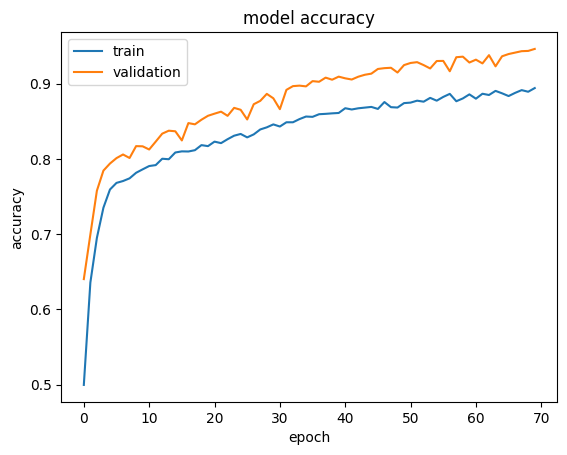

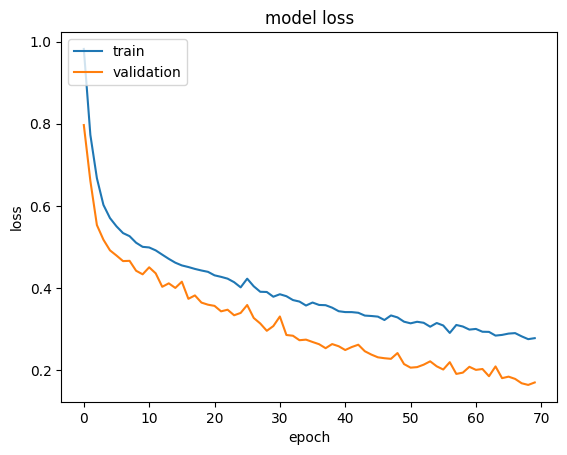

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

377/377 [==============================] - 115s 302ms/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Category, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='weighted'))

(0.9460670428144706, 0.9460670428144706, 0.9460670428144706, None)
(0.9459570307565732, 0.945935264441825, 0.94587333352516, None)
(0.9459794642779512, 0.9460670428144706, 0.9459507764365074, None)



F1 Score: 94.61


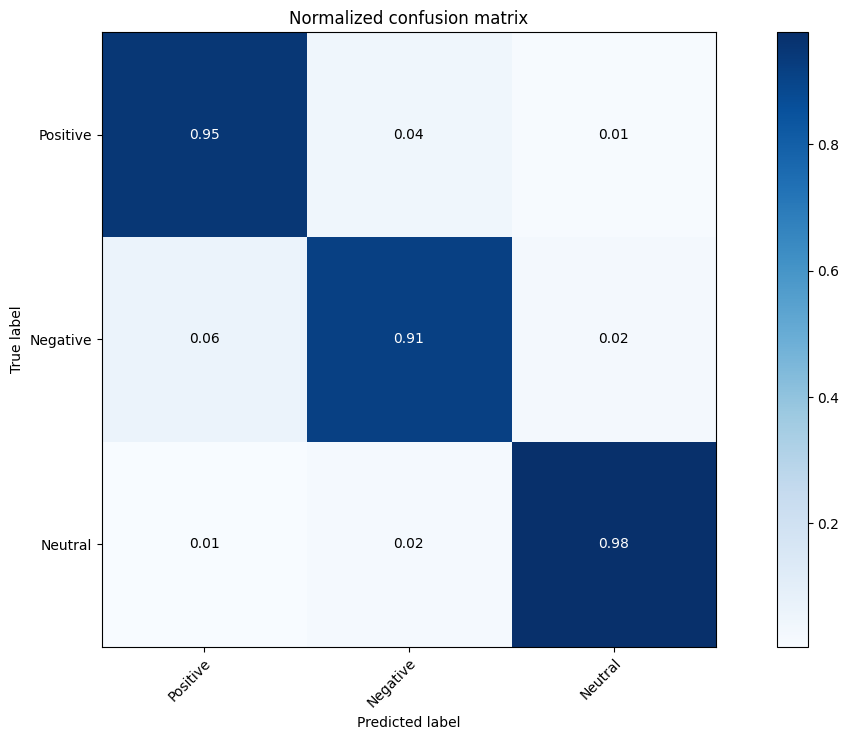

Message: It was a pleasure to use. Not an avid traveller so relied on uber to make my journey and what a breeze it was!
Predicted: Positive


In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Category, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Category, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Category, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Category, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Category, predictions, target_names=class_names))


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.95
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

              precision    recall  f1-score   support

    Positive       0.93      0.95      0.94      4042
    Negative       0.94      0.91      0.93      3980
     Neutral       0.97      0.98      0.97      4030

    accuracy                           0.95     12052
   macro avg       0.95      0.95      0.95     12052
weighted avg       0.95      0.95      0.95     12052



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Category, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


Sensitivity :  0.9386653581943082
Specificity :  0.9553688632186925
false positive rate :  0.04463113678130743
false negative rate :  0.061334641805691856
Negative Predictive Value :  0.9357161223965029
False Discovery rate :  0.04254254254254254


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Category, predictions))

377/377 [==============================] - 116s 308ms/step
Mean Absolute Error: 0.073556095
377/377 [==============================] - 128s 341ms/step
Mean Squared Error: 0.029692898
377/377 [==============================] - 122s 323ms/step
Root Mean Squared Error: 0.17231627
Cohen_Kappa_Score: 0.9190940700553353


**2. BiLSTM**

In [ ]:
embedd_layer = Embedding(vocab_size,
                         GLOVE_DIM,
                         input_length = max_seq_len,
                         weights = [emb_matrix],
                         trainable=False)

lstm_size = 128

In [ ]:
model = Sequential()
model.add(embedd_layer)

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(lstm_size, return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(lstm_size)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         2295400   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 1000, 200)         0         
 alDropout1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 1000, 32)          19232     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 500, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 250, 32)          

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

(12052, 1000)
(12052, 3)
(12052, 1000)
(12052, 3)


In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/70
48/48 [==============================] - 535s 11s/step - loss: 0.9187 - accuracy: 0.5300 - val_loss: 0.7253 - val_accuracy: 0.6064
Epoch 2/70
48/48 [==============================] - 548s 12s/step - loss: 0.7272 - accuracy: 0.6625 - val_loss: 0.6211 - val_accuracy: 0.7247
Epoch 3/70
48/48 [==============================] - 514s 11s/step - loss: 0.6353 - accuracy: 0.7205 - val_loss: 0.5454 - val_accuracy: 0.7663
Epoch 4/70
48/48 [==============================] - 534s 11s/step - loss: 0.5943 - accuracy: 0.7423 - val_loss: 0.5115 - val_accuracy: 0.7805
Epoch 5/70
48/48 [==============================] - 512s 11s/step - loss: 0.5661 - accuracy: 0.7554 - val_loss: 0.5002 - val_accuracy: 0.7868
Epoch 6/70
48/48 [==============================] - 527s 11s/step - loss: 0.5495 - accuracy: 0.7649 - val_loss: 0.4992 - val_accuracy: 0.7816
Epoch 7/70
48/48 [==============================] - 569s 12s/step - loss: 0.5395 - accuracy: 0.7659 - val_loss: 0.4749 - val_accuracy: 0.7916
Epoch 

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Category, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='weighted'))

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Category, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Category, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Category, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Category, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Category, predictions, target_names=class_names))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Category, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Category, predictions))

**3. GRU**

In [ ]:
embedd_layer = Embedding(vocab_size,
                         GLOVE_DIM,
                         input_length=max_seq_len,
                         weights=[emb_matrix],
                         trainable=False)

gru_size = 128

In [ ]:
model = Sequential()
model.add(embedd_layer)

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.5))

model.add(GRU(gru_size, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(gru_size))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Category, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='weighted'))

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Category, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Category, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Category, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Category, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Category, predictions, target_names=class_names))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Category, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Category, predictions))

**4. BiGRU**

In [ ]:
embedd_layer = Embedding(vocab_size,
                         GLOVE_DIM,
                         input_length=max_seq_len,
                         weights=[emb_matrix],
                         trainable=False)

In [ ]:
gru_size = 128

model = Sequential()
model.add(embedd_layer)

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.5))

model.add(Bidirectional(GRU(gru_size, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(gru_size)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Category, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Category, predictions, average='weighted'))

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Category, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Category, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Category, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Category, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Category, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Category, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Category, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Category, predictions, target_names=class_names))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Category, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Category, predictions))